# Chapter 2: Taking Earth's Temperature

### PART II: Comparing re-analysis with observations since 1950 <a class="anchor" id="chapter-one"></a>

Now that we have looked at the long-term evolution of temperture in different datasets, we want to focus on the last century, where reanalysis data exists. Reanalysis is a scientific method for developing a comprehensive record of how weather and climate are changing over time. It involves using a fixed version of a weather forecasting model and assimilating historical weather observations to generate a synthesized estimate of the state of the Earth's atmospheric conditions over time. The ECMWF's ERA5 is one of the most advanced global atmospheric reanalyses to date, providing hourly data on many atmospheric, land-surface, and sea-state parameters from 1940 onwards.

In the following we want to assess the validity of surface air temperatures obtained from ERA5 by comparing them to observational data. Here we take [E-OBS](https://www.ecad.eu/download/ensembles/download.php) as observational reference, which is a gridded dataset that provides daily observations of a number of weather variables, such as precipitation, temperature, and sea-level pressure, across Europe.


<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-cams/master?labpath=vis-animations.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-cams/blob/master/vis-animations.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-cams/blob/master/vis-animations.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

In [1]:
# Python Standard Libraries
import os
import calendar
import tarfile

# Data Manipulation Libraries
import numpy as np
import pandas as pd
import xarray as xr
import regionmask as rm
import dask

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask.diagnostics.progress import ProgressBar

# Climate Data Store API for retrieving climate data
import cdsapi


In [2]:
plt.style.use(
    "../copernicus.mplstyle"
)  # Set the visual style of the plots; not necessary for the tutorial

In [3]:
dask.config.set(**{"array.slicing.split_large_chunks": True})

In [4]:
# Boolean land-sea mask
lsm = rm.defined_regions.natural_earth_v5_0_0.land_110

In [5]:
# Define regions of interest
# =============================================================================
# Some regions are defined here: https://climate.copernicus.eu/esotc/2022/about-data#Regiondefinitions
REGIONS = {
    "Global": {"lon": slice(-180, 180), "lat": slice(-90, 90)},
    "Northern Hemisphere": {"lon": slice(-180, 180), "lat": slice(0, 90)},
    "Southern Hemisphere": {"lon": slice(-180, 180), "lat": slice(-90, 0)},
    "Europe": {"lon": slice(-25, 40), "lat": slice(34, 72)},
    "Arctic": {"lon": slice(-180, 180), "lat": slice(66.6, 90)},
}


In [6]:
# Define some parameters that can be easily changed
PROJS = {
    "Europe": ccrs.TransverseMercator(central_longitude=15, central_latitude=52),
    "Arctic": ccrs.Orthographic(central_longitude=0, central_latitude=90),
    "Global": ccrs.EqualEarth(),
    "Data": ccrs.PlateCarree(),
}

In [7]:
# Define climatology period
# =============================================================================
REF_PERIOD = {"time": slice("1991", "2020")}

In [8]:
file_name = {}  # dictionary containing [data source : file name]

file_name.update({"era5": "temperature_era5.nc"})
file_name.update({"eobs": "temperature_eobs.tar.gz"})

# Create the paths to the files
path_to = {
    source: os.path.join(f"data/{source}/", file) for source, file in file_name.items()
}

# Create necessary directories if they do not exist
for path in path_to.values():
    os.makedirs(
        os.path.dirname(path), exist_ok=True
    )  # create the folder if not available

path_to

{'era5': 'data/era5/temperature_era5.nc',
 'eobs': 'data/eobs/temperature_eobs.tar.gz'}

In [9]:
def coordinate_is_monthly(ds, coord: str = "time"):
    """Return True if the coordinates are months"""
    time_diffs = np.diff(ds.coords[coord].values)
    time_diffs = pd.to_timedelta(time_diffs).days

    # If all differences are between 28 and 31 days
    if np.all((28 <= time_diffs) & (time_diffs <= 31)):
        return True
    else:
        return False


In [10]:

def streamline_coords(da):
    """Streamline the coordinates of a DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The DataArray to streamline.
    """

    # Ensure that time coordinate is fixed to the first day of the month
    if "time" in da.coords:
        if coordinate_is_monthly(da, "time"):
            da.coords["time"] = da["time"].to_index().to_period("M").to_timestamp()

    # Ensure that spatial coordinates are called 'lon' and 'lat'
    if "longitude" in da.coords:
        da = da.rename({"longitude": "lon"})
    if "latitude" in da.coords:
        da = da.rename({"latitude": "lat"})

    # Ensure that lon/lat are sorted in ascending order
    da = da.sortby("lat")
    da = da.sortby("lon")

    # Ensure that lon is in the range [-180, 180]
    lon_min = da["lon"].min()
    lon_max = da["lon"].max()
    if lon_min < -180 or lon_max > 180:
        da.coords["lon"] = (da.coords["lon"] + 180) % 360 - 180
        da = da.sortby(da.lon)

    return da

##### ERA5 reanalysis

Now, let's retrieve our data from the CDS using the `cdsapi.Client()`. Here, we download the reanalysis ERA5 single levels monthly means data for the variable '2m_temperature' from 1950 to 2022.

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    For efficiency and to expedite processing time, we are opting to download the data at a coarser resolution of 1x1 degree, as opposed to the highest (default) resolution of 0.25x0.25 degree. Please be aware that this could lead to minor discrepancies when compared to figures published in <a href="https://climate.copernicus.eu/climate-bulletins">climate intelligence bulletins.</a>
</div>

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    For efficiency and to expedite processing time, we are opting to download the data at a coarser resolution of 1x1 degree, as opposed to the highest (default) resolution of 0.25x0.25 degree. Please be aware that this could lead to minor discrepancies when compared to figures published in <a href="https://climate.copernicus.eu/climate-bulletins">climate intelligence bulletins.</a>
</div>

In [ ]:
c = cdsapi.Client()

c.retrieve(
  'reanalysis-era5-single-levels-monthly-means',
  {
    'format': 'netcdf',
    'product_type': 'monthly_averaged_reanalysis',
    'variable': ['2m_temperature', 'land_sea_mask'],
    'year': list(range(1950, 2023)),
    'month': list(range(1, 13)),
    'time': '00:00',
    # 'grid': [0.25, 0.25],
  },
  path_to['era5']
)

In [19]:
with xr.open_mfdataset(path_to["era5"]) as era5:
    # convert from Kelvin to Celsius
    era5["t2m"] = era5["t2m"] - 273.15
era5 = streamline_coords(era5)
era5_monthly_climatology = era5["t2m"].sel(REF_PERIOD).groupby("time.month").mean()
era5["anom"] = era5["t2m"].groupby("time.month") - era5_monthly_climatology

# Europe only
with ProgressBar():
    era5_europe = era5.sel(REGIONS["Europe"]).compute()

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 73 times more chunks
  return self.array[key]


[########################################] | 100% Completed | 187.55 s


In [20]:
def weighted_spatial_average(da, region, land_mask=None):
    """Calculate the weighted spatial average of a DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The DataArray to average.
    weights : xr.DataArray, optional
        A DataArray with the same dimensions as `da` containing the weights.
    """
    da = da.sel(**region)

    # Area weighting: calculate the area of each grid cell
    weights = np.cos(np.deg2rad(da.lat))

    # Additional user-specified weights, e.g. land-sea mask
    if land_mask is not None:
        land_mask = land_mask.sel(**region)
        weights = weights * land_mask.fillna(0)

    return da.weighted(weights).mean(("lat", "lon"))

#### E-OBS

<div class="alert alert-block alert-info">
<b>NOTE</b>: <br>
    Please note that the time to request and download the data may vary as it depends on several factors. It typically should take less than 10 minutes though.
</div>

<div class="alert alert-block alert-info">
<b>NOTE</b>: <br>
    The gridded E-OBS data set is available at high (0.1º) or low (0.25º) resolution. Here we take the low resolution data set to speed up the downloading process.
</div>

c = cdsapi.Client()

c.retrieve(
    'insitu-gridded-observations-europe',
    {
        'format': 'tgz',
        'product_type': 'ensemble_mean',
        'variable': 'mean_temperature',
        'grid_resolution': '0.25deg',
        'period': 'full_period',
        'version': '27.0e',
    },
    path_to['eobs']
)

In [12]:
 # open file
file = tarfile.open(path_to['eobs'])
  
# print file names
print(file.getnames())
  
# extract files
file.extractall('data/eobs')

['tg_ens_mean_0.25deg_reg_v27.0e.nc']


In [13]:
eobs_daily = xr.open_mfdataset("data/eobs/tg_ens_mean_0.25deg_reg_v27.0e.nc")
eobs_daily = streamline_coords(eobs_daily)

In [14]:
# Figure 1. Annual European land surface air temperature anomalies for
# 1950 to 2022, relative to the 1991–2020 reference period.
# =============================================================================
# Select the region of interest
eobs_daily_europe = eobs_daily.sel(REGIONS["Europe"])
# Convert EOBS to monthly
eobs_europe = eobs_daily_europe.resample(time="MS", skipna=False).mean("time")
with ProgressBar():
    eobs_europe = eobs_europe.compute()

# Calculate the monthly climatology
eobs_monthly_climatology = (
    eobs_europe["tg"].sel(REF_PERIOD).groupby("time.month").mean()
)
eobs_europe["anom"] = eobs_europe["tg"].groupby("time.month") - eobs_monthly_climatology
eobs_europe["climatology"] = eobs_monthly_climatology


[########################################] | 100% Completed | 72.71 s


In [15]:
def convert_coords_time_to_year_month(ds):
    """Convert the coordinates of a DataArray from "time" to ("year", "month")"""
    year = ds.time.dt.year
    month = ds.time.dt.month

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return ds.set_index(time=("year", "month")).unstack("time")


In [16]:

def weighted_annual_average(da):
    """Calculate the weighted annual average per year."""
    days_in_month = da.time.dt.days_in_month
    weights = (
        days_in_month.groupby("time.year") / days_in_month.groupby("time.year").sum()
    )
    nominator = (da * weights).resample({"time": "AS"}).sum(skipna=False)
    denominator = weights.resample({"time": "AS"}).sum()
    np.testing.assert_allclose(denominator, 1)
    return nominator / denominator

In [17]:
# Calculate the monthly climatology
def annual_anomalies(da, land_mask=None):
    # 1. Calculate the spatial average
    da = weighted_spatial_average(da, REGIONS["Europe"], land_mask)
    # 2. Calculate the weighted (per days in month) annual average
    waa = weighted_annual_average(da)
    # 3. Convert the coordinates from "time" to ("year", "month")
    return convert_coords_time_to_year_month(waa).sel(month=1, drop=True)


In [21]:
eobs_europe_anom = annual_anomalies(eobs_europe["anom"], land_mask=None)
era5_europe_anom = annual_anomalies(era5_europe["anom"], land_mask=era5_europe["lsm"])

eobs_europe_anom.name = "EOBS"
era5_europe_anom.name = "ERA5"

In [22]:
def barplot_temperature(da1, da2, title=""):
    # make red and blue colors for above and below zero
    clrs = sns.color_palette("Paired", n_colors=6)
    clrs_da1 = [clrs[0] if anom < 0 else clrs[4] for anom in da1.values]
    clrs_da2 = [clrs[1] if anom < 0 else clrs[5] for anom in da2.values]

    fig = plt.figure(figsize=(14, 5))
    ax = fig.add_subplot(111)
    ax.bar(
        da1.year,
        da1,
        color=clrs_da1,
        label=da1.name,
        zorder=1,
    )
    ax.bar(
        da2.year,
        da2,
        0.25,
        color=clrs_da2,
        label="ERA5",
        zorder=2,
    )
    # Add a annoation for both datasets pointing to the last bar at the right hand side
    # with text "ERA5" and "EOBS" respectively. The text should be in the same color as
    # the bar.
    da1_final_data = (da1[-1].year.item(), da1[-1].item())
    da2_final_data = (da2[-1].year.item(), da2[-1].item())
    ax.annotate(
        da1.name,
        xy=da2_final_data,
        xytext=(2023, 1.4),
        arrowprops=dict(arrowstyle="-|>", color=clrs[5]),
        color=clrs[4],
        ha="left",
        xycoords="data",
    )
    ax.annotate(
        da2.name,
        xy=da1_final_data,
        xytext=(2023, 0.3),
        color=clrs[5],
        arrowprops=dict(arrowstyle="-|>", color=clrs[4]),
        ha="left",
        xycoords="data",
    )
    ax.axhline(0, color=".5", lw=0.5, ls="--")
    ax.set_title(title)
    sns.despine(ax=ax, offset=5, trim=True)
    plt.show()

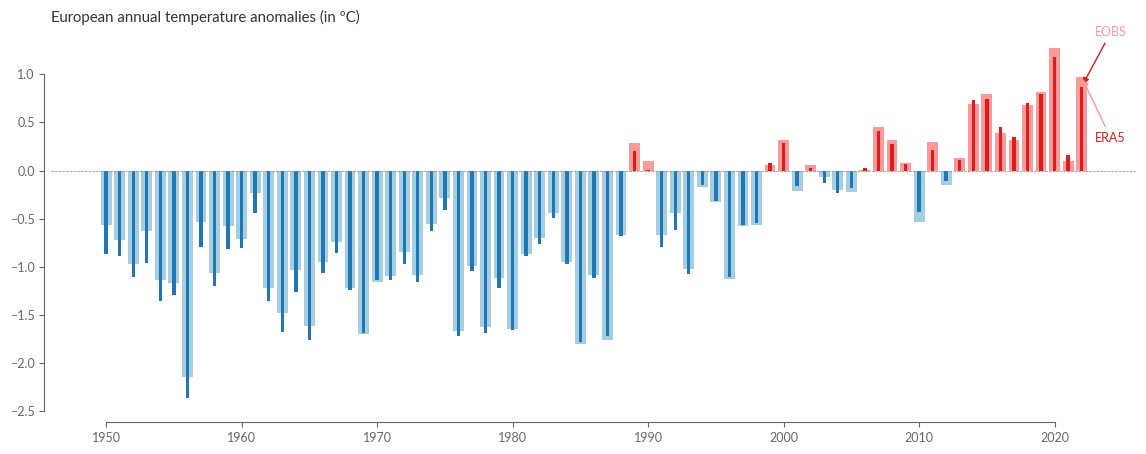

In [23]:
title = "European annual temperature anomalies (in ºC)"
barplot_temperature(eobs_europe_anom, era5_europe_anom, title)

In [24]:
diff = era5_europe_anom - eobs_europe_anom

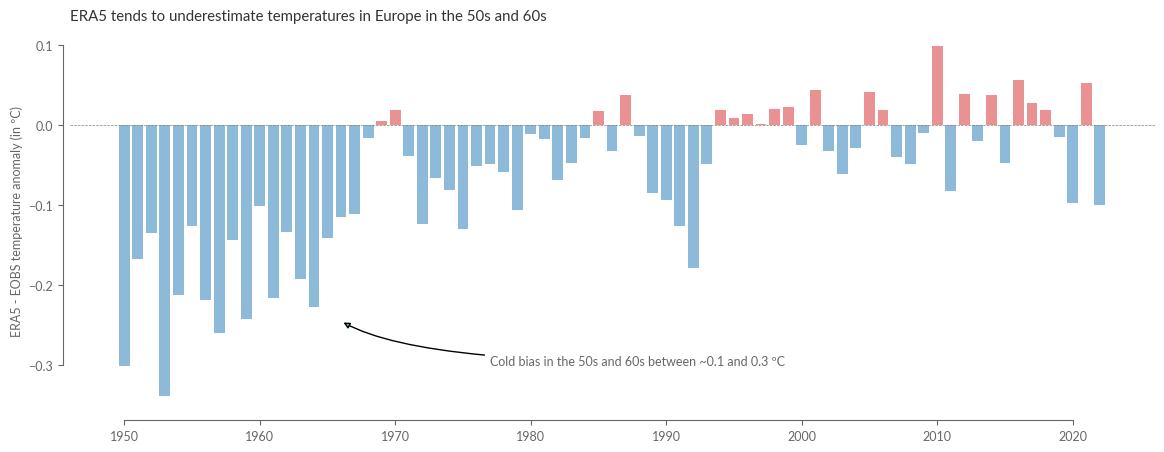

In [25]:
clrs_diff = np.where(diff > 0, "tab:red", "tab:blue")

fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(111)
ax.bar(
    diff.year,
    diff,
    color=clrs_diff,
    label="",
    alpha=0.5,
)
ax.axhline(0, color=".5", lw=0.5, ls="--")
ax.set_title("ERA5 tends to underestimate temperatures in Europe in the 50s and 60s")
# Make a annotation pointing to (-.25, "1965") with text "ERA5 underestimates"
ax.annotate(
    "Cold bias in the 50s and 60s between ~0.1 and 0.3 ºC",
    xy=(1966, -0.245),
    xytext=(1977, -0.3),
    # make a curved arrow
    arrowprops=dict(
        arrowstyle="-|>",
        connectionstyle="angle3,angleA=0,angleB=-30",
    ),
    ha="left",
    xycoords="data",
)
ax.set_ylabel("ERA5 - EOBS temperature anomaly (in ºC)")
sns.despine(ax=ax, offset=5, trim=True)


In [26]:
# Figure 2. Average surface air temperature anomaly for 2022,
# relative to the 1991–2020 reference period.
# =============================================================================

eobs_yearly_anoms = weighted_annual_average(eobs_europe["anom"])
era5_yearly_anoms = weighted_annual_average(era5_europe["anom"])

eobs_yearly_anoms = convert_coords_time_to_year_month(eobs_yearly_anoms).sel(month=1)
era5_yearly_anoms = convert_coords_time_to_year_month(era5_yearly_anoms).sel(month=1)

In [27]:
def spatial_plot_temperature(da1, da2, year):
    proj = ccrs.Orthographic(central_longitude=10, central_latitude=45)
    fig = plt.figure(figsize=(14, 5))
    gs = GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 0.05], wspace=0.02)
    ax1 = fig.add_subplot(gs[0, 0], projection=PROJS["Europe"])
    ax2 = fig.add_subplot(gs[0, 1], projection=PROJS["Europe"])
    cax = fig.add_subplot(gs[0, 2])
    for ax in [ax1, ax2]:
        ax.coastlines("50m", lw=0.5)
        ax.add_feature(cfeature.OCEAN, facecolor=".6")
        ax.add_feature(cfeature.LAND, facecolor=".8")
        ax.set_extent([-25, 40, 34, 72], crs=PROJS["Data"])

    levels = np.arange(-3, 3.5, 0.5)
    kwargs = dict(
        levels=levels,
        transform=PROJS["Data"],
        cmap="RdYlBu_r",
        cbar_kwargs=dict(label="Temperature anomaly (ºC)"),
    )
    da1.sel(year=year).plot(ax=ax1, cbar_ax=cax, **kwargs)
    da2.sel(year=year).plot(ax=ax2, cbar_ax=cax, **kwargs)

    da1_dist = da1.sel(year=year).stack(x=("lat", "lon")).dropna("x").values
    da2_dist = da2.sel(year=year).stack(x=("lat", "lon")).dropna("x").values
    cax.boxplot(
        np.concatenate([da1_dist, da2_dist]),
        vert=True,
        positions=[0.5],
        whis=(5, 95),
        widths=0.5,
        flierprops=dict(marker=".", markersize=1),
    )
    cax.set_xticks([])
    ax1.set_title(f"{da1.name} ({year})")
    ax2.set_title(f"{da2.name} ({year})")


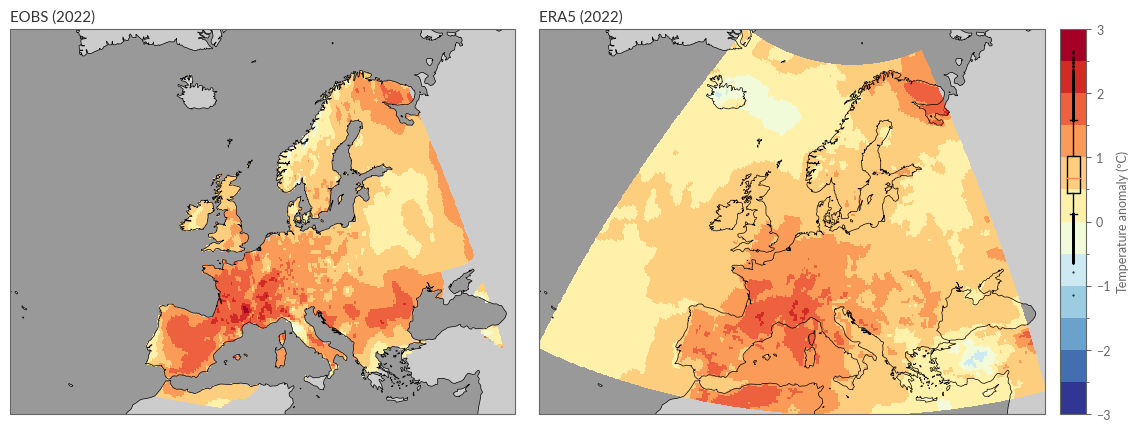

In [28]:
YEAR = 2022

eobs_yearly_anoms.name = "EOBS"
era5_yearly_anoms.name = "ERA5"

spatial_plot_temperature(eobs_yearly_anoms, era5_yearly_anoms, YEAR)

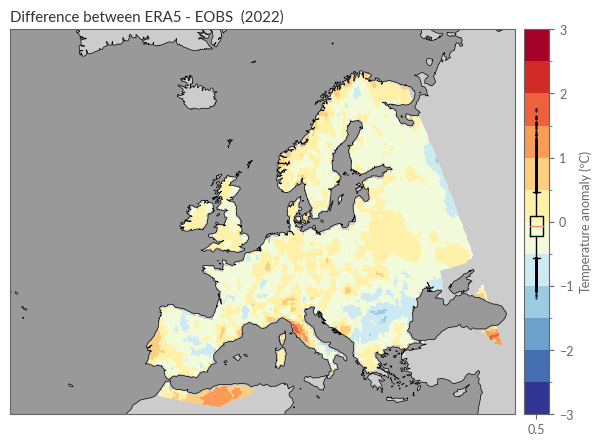

In [29]:
diff = era5_yearly_anoms - eobs_yearly_anoms.interp_like(era5_yearly_anoms)

levels = np.arange(-3, 3.5, 0.5)
kwargs = dict(
    levels=levels,
    transform=PROJS["Data"],
    cmap="RdYlBu_r",
    cbar_kwargs=dict(label="Temperature anomaly (ºC)"),
)
fig = plt.figure(figsize=(7, 5))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1, 0.05], wspace=0.02)
ax1 = fig.add_subplot(gs[0, 0], projection=PROJS["Europe"])
cax = fig.add_subplot(gs[0, 1])
ax1.coastlines("50m", lw=0.5)
ax1.add_feature(cfeature.OCEAN, facecolor=".6")
ax1.add_feature(cfeature.LAND, facecolor=".8")
ax1.set_extent([-25, 40, 34, 72], crs=ccrs.PlateCarree())
diff.sel(year=YEAR).plot(ax=ax1, cbar_ax=cax, **kwargs)
ax1.set_title(f"Difference between ERA5 - EOBS  ({YEAR})")
dist = diff.sel(year=YEAR).stack(x=("lat", "lon")).dropna("x").values
cax.boxplot(
    dist,
    vert=True,
    positions=[0.5],
    whis=(5, 95),
    widths=0.5,
    flierprops=dict(marker=".", markersize=1),
)
plt.show()


In [30]:
# Figure 3a. European land surface air temperature anomalies
# for SEASONS, relative to the average for the 1991–2020 reference period.
# -----------------------------------------------------------------------------
def weighted_seasonal_average(ds):
    """Calculate the weighted seasonal average per year and grid point.

    Important: in case there are missing values in the data the weighted average will be wrong.
    """
    month_length = ds.time.dt.days_in_month
    ds_weighted_sum = (ds * month_length).resample(time="QS-DEC").sum(skipna=False)
    sum_of_weights = month_length.resample(time="QS-DEC").sum()
    return ds_weighted_sum / sum_of_weights


def convert_time_to_year_season(ds):
    """Convert the coordinates of a DataArray from "time" to ("year", "season")"""
    year = ds.time.dt.year
    season = ds.time.dt.season

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), season=("time", season.data))

    # reshape the array to (..., "season", "year")
    return ds.set_index(time=("year", "season")).unstack("time")


In [31]:
# Figure 3a. European land surface air temperature anomalies
# for SEASONS, relative to the average for the 1991–2020 reference period.
# -----------------------------------------------------------------------------
def weighted_seasonal_average(ds):
    """Calculate the weighted seasonal average per year and grid point.

    Important: in case there are missing values in the data the weighted average will be wrong.
    """
    month_length = ds.time.dt.days_in_month
    ds_weighted_sum = (ds * month_length).resample(time="QS-DEC").sum(skipna=False)
    sum_of_weights = month_length.resample(time="QS-DEC").sum()
    return ds_weighted_sum / sum_of_weights


def convert_time_to_year_season(ds):
    """Convert the coordinates of a DataArray from "time" to ("year", "season")"""
    year = ds.time.dt.year
    season = ds.time.dt.season

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), season=("time", season.data))

    # reshape the array to (..., "season", "year")
    return ds.set_index(time=("year", "season")).unstack("time")


In [32]:
eobs_seasonal = weighted_seasonal_average(eobs_europe)
era5_seasonal = weighted_seasonal_average(era5_europe)

eobs_seasonal.coords.update({"time": eobs_seasonal.time + pd.Timedelta(days=31)})
era5_seasonal.coords.update({"time": era5_seasonal.time + pd.Timedelta(days=31)})

eobs_seasonal = convert_time_to_year_season(eobs_seasonal)
era5_seasonal = convert_time_to_year_season(era5_seasonal)

eobs_seasonal.loc[dict(season="DJF", year=[1950, 2023])] = np.nan
era5_seasonal.loc[dict(season="DJF", year=[1950, 2023])] = np.nan


In [33]:
eobs_seasonal_average = weighted_spatial_average(
    eobs_seasonal["anom"], REGIONS["Europe"]
)
era5_seasonal_average = weighted_spatial_average(
    era5_seasonal["anom"], REGIONS["Europe"], land_mask=era5_seasonal["lsm"]
)

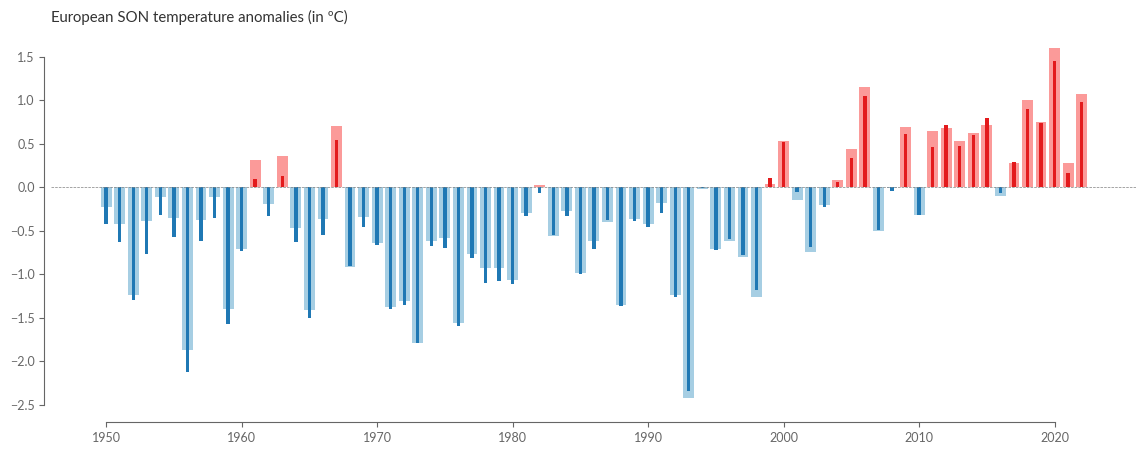

In [34]:
eobs_seasonal_average.name = "EOBS"
era5_seasonal_average.name = "ERA5"

SEASON = "SON"

title = f"European {SEASON} temperature anomalies (in ºC)"
barplot_temperature(
    eobs_seasonal_average.sel(season=SEASON, drop=True),
    era5_seasonal_average.sel(season=SEASON, drop=True),
    title,
)


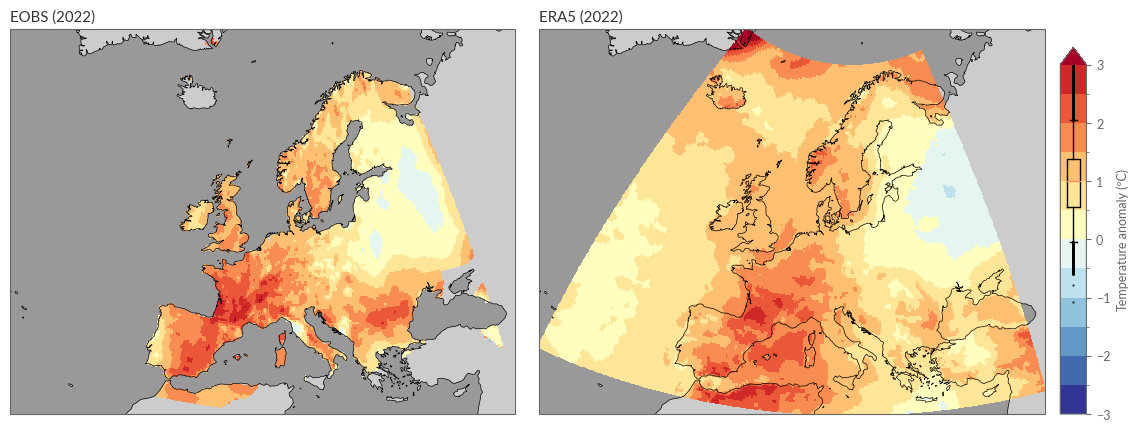

In [35]:
# Figure 4b. Surface air temperature anomalies for winter, spring, summer
# and autumn 2022, relative to the respective seasonal average for the
# 1991–2020 reference period.
# -----------------------------------------------------------------------------
eobs_seasonal_anom = eobs_seasonal["anom"].sel(season=SEASON)
era5_seasonal_anom = era5_seasonal["anom"].sel(season=SEASON)

eobs_seasonal_anom.name = "EOBS"
era5_seasonal_anom.name = "ERA5"

spatial_plot_temperature(
    eobs_seasonal_anom,
    era5_seasonal_anom,
    YEAR,
)


In [36]:
# Figure 5. Average surface air temperature anomalies for each month
# of 2022, relative to the respective monthly average for the 1991–2020
# reference period. Data source: ERA5. Credit: C3S/ECMWF.
# -----------------------------------------------------------------------------
def plot_monthly_overview(da, title, **kwargs):
    da = convert_coords_time_to_year_month(da)
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(
        4, 4, figure=fig, wspace=0.02, hspace=0.02, width_ratios=[1, 1, 1, 0.05]
    )
    axes = [
        fig.add_subplot(gs[i // 3, i % 3], projection=PROJS["Europe"])
        for i in range(12)
    ]
    cax = fig.add_subplot(gs[:, 3])

    for ax, month in zip(axes, da.month.values):
        da.sel(month=month).plot(ax=ax, cbar_ax=cax, **kwargs)
        ax.set_title("")
        ax.coastlines("50m", lw=0.5)
        ax.add_feature(cfeature.OCEAN, facecolor=".6")
        ax.add_feature(cfeature.LAND, facecolor=".8")
        ax.text(
            0.02,
            0.98,
            calendar.month_name[month],
            transform=ax.transAxes,
            ha="left",
            va="top",
            fontsize=12,
            bbox=dict(facecolor="w", edgecolor="w", boxstyle="round", alpha=0.8),
        )

    fig.suptitle(title, y=0.91)

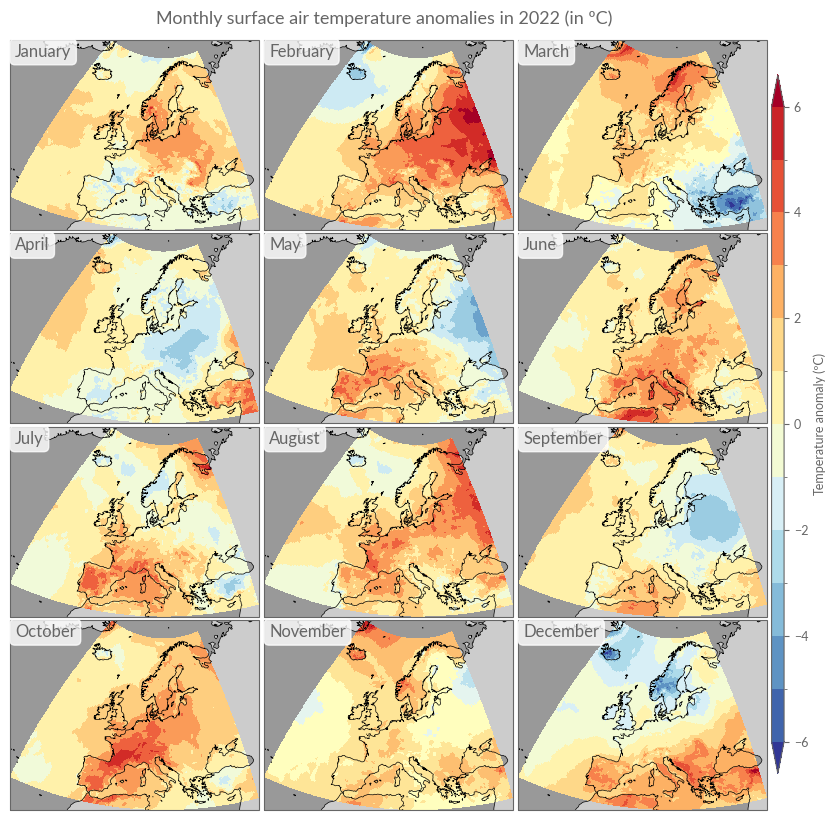

In [37]:
title = "Monthly surface air temperature anomalies in 2022 (in ºC)"
kwargs.update({"levels": np.arange(-6, 6.5, 1.0), "vmin": -6, "vmax": 6})
plot_monthly_overview(era5_europe["anom"].sel(time="2022"), title, **kwargs)

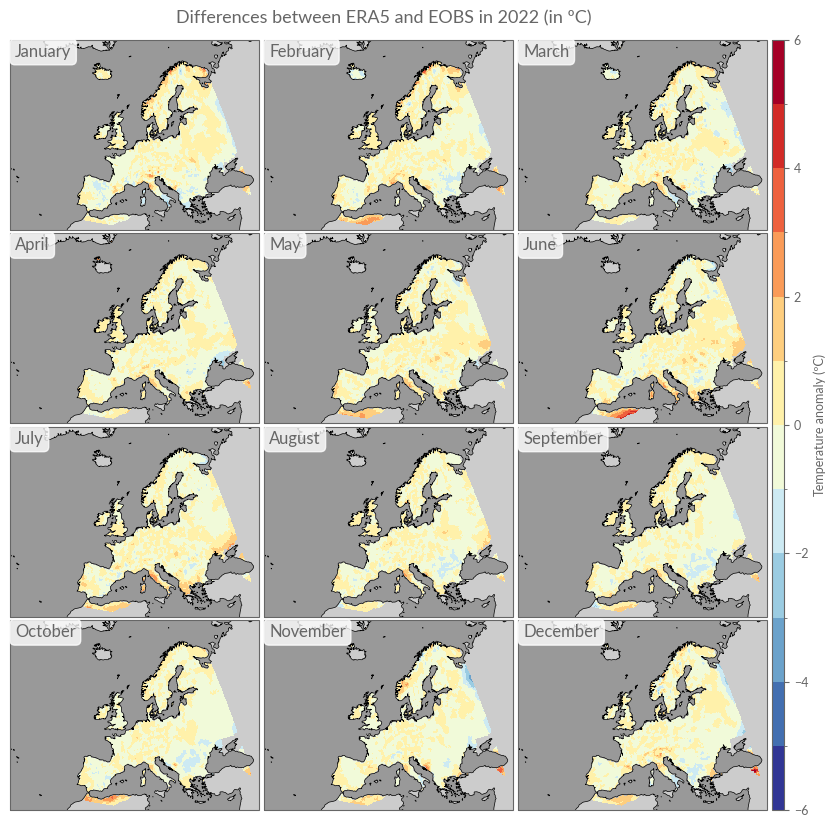

In [38]:
monthly_diffs = era5_europe["anom"].sel(time="2022") - eobs_europe["anom"].sel(
    time="2022"
).interp_like(era5_europe["anom"])
title = "Differences between ERA5 and EOBS in 2022 (in ºC)"
kwargs.update({"levels": np.arange(-6, 6.1, 1.0), "vmin": -6, "vmax": 6})
plot_monthly_overview(monthly_diffs, title, **kwargs)

In [39]:
eobs_daily_mean = weighted_spatial_average(eobs_daily_europe["tg"], REGIONS["Europe"])

with ProgressBar():
    eobs_daily_mean = eobs_daily_mean.compute()



[########################################] | 100% Completed | 107.11 s


In [ ]:

# %%
eobs_2022 = eobs_daily_mean.sel(time="2022").groupby("time.dayofyear").mean()

eobs_windowed = (
    eobs_daily_mean.sel(REF_PERIOD)
    .rolling(time=31, center=True)
    .construct("window_dim")
)
eobs_daily_quantiles = eobs_windowed.groupby("time.dayofyear").quantile(
    [0.1, 0.5, 0.9], dim=["time", "window_dim"]
)
lower, median, upper = eobs_daily_quantiles.sel(dayofyear=slice(1, 365)).transpose(
    "quantile", "dayofyear"
)


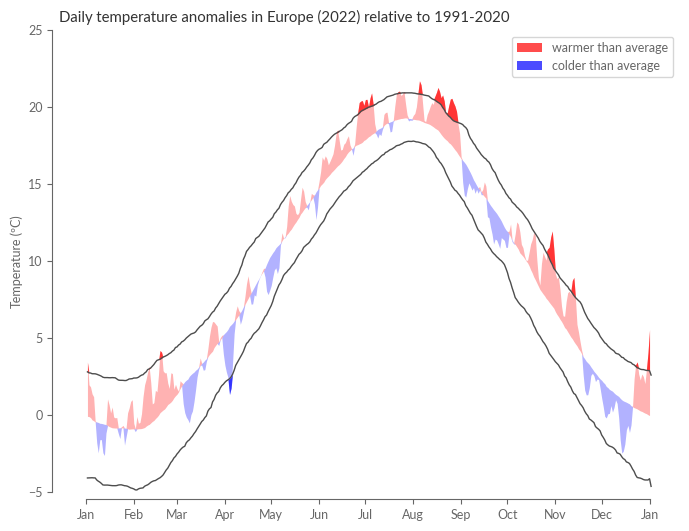

In [40]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
eobs_daily_quantiles.sel(quantile=[0.1, 0.9]).plot.line(
    ax=ax, x="dayofyear", lw=1, color=".3"
)
ax.fill_between(
    median.dayofyear,
    eobs_2022.where(eobs_2022 >= median, median),
    median,
    color="red",
    alpha=0.3,
    lw=0,
    zorder=-1,
)
ax.fill_between(
    median.dayofyear,
    eobs_2022.where(eobs_2022 <= median, median),
    median,
    color="blue",
    alpha=0.3,
    lw=0,
    zorder=-1,
)

ax.fill_between(
    median.dayofyear,
    eobs_2022.where(eobs_2022 >= upper, upper),
    upper,
    color="red",
    alpha=0.7,
    lw=0,
    zorder=1,
    label="warmer than average",
)
ax.fill_between(
    median.dayofyear,
    eobs_2022.where(eobs_2022 <= lower, lower),
    lower,
    color="blue",
    alpha=0.7,
    lw=0,
    zorder=1,
    label="colder than average",
)

days_in_month_2022 = (
    eobs_daily_europe.time.dt.days_in_month.sel(time="2022")
    .resample({"time": "MS"})
    .mean()
)
ax.legend()
xticks = [0] + days_in_month_2022.cumsum().values.tolist()
xticklabels = [calendar.month_abbr[x % 12 + 1] for x in range(len(xticks))]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylim(-5, 25)
ax.set_xlabel("")
ax.set_ylabel("Temperature (ºC)")
ax.set_title("Daily temperature anomalies in Europe (2022) relative to 1991-2020")
sns.despine(ax=ax, offset=5, trim=True)